## Helpers

In [29]:
# Helper variables
street_types = ['street', 'st', 'drive', 'dr', 'lane', 'road', 'rd', 'avenue', 'ave', 'av', 'estate']
street_types_regex = '|'.join(street_types)

weekly_terms = ['pw', 'week', '/w', 'p.w.', 'p.w', 'p/w', 'wk']
monthly_terms = ['pcm', 'month', 'p.c.m', 'pm', 'p/m']
yearly_terms = ['year', 'annum']

# could contain both pw and pcm

mapping = {
    'House': 'House',
    'Apartment / Unit / Flat': 'Apartment',
    'Townhouse': 'House',
    'Studio': 'Apartment', 
    'Villa': 'House',
    'New House & Land': 'House',
    'New Apartments / Off the Plan': 'Apartment',
    'Semi-Detached': 'House',
    'Duplex': 'House',
    'Terrace': 'House',
}

# Helper functions

def extract_parkings(text):
    ''' A function that returns the number of parking spaces'''
    match = re.search(r'\d+', text)
    if match:
        return int(match.group())
    else:
        return 0

def extract_bed_bath(rooms):
    ''' A function that extracts the number of bedrooms and bathrooms'''
    bed_match = re.search(r"(\d+)\s*Bed", rooms)
    bath_match = re.search(r"(\d+)\s*Bath", rooms)

    bed = int(bed_match.group(1)) if bed_match else None
    bath = int(bath_match.group(1)) if bath_match else None
    
    return pd.Series([bed, bath])

def contains_number(text):
    ''' A function that returns True if the text contains at least 2 digits'''
    # 2 digits to avoid entries like "6 month lease available"
    return bool(re.search(r'\d{2,}', text))

def remove_postcode(address):
    '''A function that removes all instances of the postcode'''
    return re.sub(r'\b\d{4}\b', '', address).strip()

def insert_commas(address):
    '''A function that inserts a comma after street types due to inconsistencies in address formats'''
    
    # Create a regex pattern to match any of the street types followed by a space (to check for the next word)
    pattern = r'(\b(?:' + street_types_regex + r')\b)(\s)'
    
    # Insert a comma after the matched street type
    return re.sub(pattern, r'\1,\2', address, flags=re.IGNORECASE)

def extract_suburb(address):
    '''A function that extracts the suburb of an address'''

    # Extract the part before 'VIC'
    vic_part = re.search(r'(.+?)\bVIC\b', address)

    if vic_part:
        # Get everything before VIC and split by commas or street types
        pre_vic = vic_part.group(1)

        # Split by street types or commas
        parts = re.split(f',|\\b(?:{street_types_regex})\\b', pre_vic)

        # Take the last part, which would be just the suburb
        return parts[-1].strip()
        
    return None

def contains_furnished_and_unfurnished(text):
    '''A function that returns True when the rental price specifies both furnished and unfurnished options'''

    furnished = re.search(r'\bfurnished\b', text, re.IGNORECASE)
    unfurnished = re.search(r'\bunfurnished\b', text, re.IGNORECASE)

    return bool(furnished and unfurnished)

def is_price_furnished(text):
    '''A function that returns indicates whether the price specficies furnishings'''
    text = text.lower()
    furnished_pattern = re.compile(r'\bfurnished\b', re.IGNORECASE)
    unfurnished_pattern = re.compile(r'\bunfurnished\b', re.IGNORECASE)
    extra_pattern = re.compile(r'\bextra\b', re.IGNORECASE)

    if unfurnished_pattern.search(text):
        if furnished_pattern.search(text):
            return True
        return False
    if furnished_pattern.search(text):
        if extra_pattern.search(text):
            return False
        return True
        
    return None

# We assume that if there's an asterisk that comes after furnished, then it's unfurnished due to the unverifiability as specified by domain.com
def is_feature_furnished(features_str):
    '''A function that determines if the features indicate whether a property is furnished'''
    pattern = r'\bFurnished\b(?!\s*\*)'
    if features_str.strip() == "[]":
        return None
    return bool(re.search(pattern, features_str, re.IGNORECASE))

def is_desc_furnished(desc):
    '''A function that determines whether a property is furnished from the descriptions'''
    desc = desc.lower()
    if 'not furn' in desc or 'unfurn' in desc:
        return False
    elif 'furnished' in desc:
        if 'option' in desc or 'extra' in desc:
            return False
        return True
    else:
        return None


def ensure_space_after_number(text):
    # Define the pattern to find numbers followed immediately by alphabet characters
    pattern = r'(\d+)([a-zA-Z])'
    # Replace matches with the number followed by a space and then the alphabet character
    result = re.sub(pattern, r'\1 \2', text)
    return result

def find_with_dollar(price):

    pattern = r'\$\s*\d+(?:,\d{3})*(?:\.\d+)?'
    matches = re.findall(pattern, price)
    numerical_values = [float(match.replace('$', '').replace(',', '').strip()) for match in matches]

    # Return the list of numerical values if any matches are found; otherwise, return None
    return numerical_values if numerical_values else None

def extract_numbers(text):
    # Define patterns to exclude phone numbers and dates
    phone_pattern = r'\b\d{3,4}[\s/-]\d{3,4}[\s/-]\d{3,4}\b|\b\d{10,11}\b'
    date_pattern = r'\b\d{1,2}[//]\d{1,2}[//]\d{2,4}\b'
    
    # Remove phone numbers and dates from the text
    text_cleaned = re.sub(phone_pattern, '', text)
    text_cleaned = re.sub(date_pattern, '', text_cleaned)
    
    # Pattern to match numbers of at least 3 digits, including commas and decimals
    pattern = r'\b\d+(?:,\d{3})*(?:\.\d+)?\b'
    
    # Find all matches in the cleaned text
    matches = re.findall(pattern, text_cleaned)
    
    # Convert matches to float after cleaning commas
    numerical_values = [float(match.replace(',', '')) for match in matches]
    
    # Handle cases where text is too short or does not fit the expected pattern
    if numerical_values:
        return numerical_values
    else:
        return None

def normalise_rent(rent_list):
    if len(rent_list) > 2:
        filtered_values = [x for x in rent_list if x > 100]
        if filtered_values:
            return [sum(filtered_values) / len(filtered_values)]
    return rent_list

def remove_bond_from_rental_price(row):

    bond_value = row['bond']
    rental_price = str(row['rental_price'])

    # Skip if bond is NaN
    if pd.notna(bond_value):

        # Create a regex pattern to match bond value, allowing optional commas and decimals
        bond_pattern = fr'\b{int(bond_value):,}(\.\d+)?\b'  # formats number with commas
        # Also include plain version without comma
        bond_pattern_alt = fr'\b{int(bond_value)}(\.\d+)?\b'

        # Remove any bond matches (with or without commas) from the rental price
        updated_rental_price = re.sub(bond_pattern, '', rental_price)
        updated_rental_price = re.sub(bond_pattern_alt, '', updated_rental_price)
        # Clean up extra spaces
        updated_rental_price = re.sub(r'\s+', ' ', updated_rental_price).strip()

        return updated_rental_price
    else:
        return rental_price


def calculate_final_rent(row):

    prices = row['rent_nums']
    
    # Case when contains_both_furnished_options is True
    if row['contains_both_furnished_options']:
        return max(prices)

    if row['is_yearly']:
        return prices[0] * 7 / 365
        
    # If it doesn't specify whether rent is paid weekly or monthly
    if row['not_indicated']:
        if len(prices) > 1:
            # Get the average
            return sum(prices) / len(prices)
        elif len(prices) == 1:
            # We assume the maximum weekly rent would be $5000 and remove those above 5000
            if prices[0] > 5000:
                return None  
            return prices[0]
        return None

    # If rent is paid exclusively monthly
    if row['is_monthly'] and not row['is_weekly']:
        if len(prices) > 1:
            return sum(prices) / len(prices) * 84 / 365
        elif len(prices) == 1:
            # We assume monthly rent should be at least $500
            if prices[0] < 500:
                return None
            return prices[0] * 84 / 365
        return None

    # If rent is paid exclusively weekly
    if row['is_weekly'] and not row['is_monthly']:
        if len(prices) > 1:
            return sum(prices) / len(prices)
        elif len(prices) == 1:
            return prices[0]
        return None

    # Take the minimum (weekly rate)
    if row['is_both']:
        return min(prices)

    # If none of the above conditions are met, return None
    return None

def summarise(df):

    final = df.groupby('suburb').agg(
        median_rent=('weekly_rent', 'median'),
        median_bath=('num_bath', 'median'),
        median_parkings=('num_parkings', 'median'),
        furnished_count=('furnished', lambda x: (x == True).sum()),
        unfurnished_count=('furnished', lambda x: (x == False).sum()),
        pets_allowed=('pets_allowed', lambda x: (x == True).sum()),
        pets_not_allowed=('pets_allowed', lambda x: (x == False).sum()),
        num_properties=('suburb', 'size')
    ).reset_index()

    # Round to the nearest integer for number of baths and parkings
    final['median_bath'] = final['median_bath'].round().astype(int)
    final['median_parkings'] = final['median_parkings'].round().astype(int)

    return final

## Start

In [30]:
import warnings
import regex as re
import pandas as pd
import matplotlib.pyplot as plt

# Suppress all warnings
warnings.filterwarnings('ignore')

# Read in the csv file (14073 entries)
properties = pd.read_csv('../data/landing/scraped_properties.csv')

## Extracting Postcode & Suburb

In [31]:
# Drop url and availability columns (irrelevant to analysis)
properties = properties.drop(columns=['url', 'availability'])

# Drop properties not in Victoria (3 properties were in NSW)
properties = properties[properties['address'].str.contains('VIC')]

# Extract the postcode of the adress
properties['postcode'] = properties['address'].str.extract(r'(\d{4})$')

# Insert commas after street names to ensure consistency
properties['address'] = properties['address'].apply(insert_commas)

# Remove all instances of the postcode from the address
properties['address'] = properties['address'].apply(remove_postcode)

# Extract the suburb of the address
properties['suburb'] = properties['address'].apply(extract_suburb)

# Get rid of address as we've extracted the main information
properties = properties.drop('address', axis = 1)

## Extracting Number of Beds, Baths & Parkings

In [32]:
# Get rid of properties that do not specify rental price (~139)
properties = properties[properties['rental_price'].apply(contains_number)]

# Only keep apartments and houses (~37)
properties['property_type'] = properties['property_type'].map(mapping)
properties = properties[~properties['property_type'].isna()]

# Remove properties that are shipping containers (~4)
properties = properties[~properties['desc'].str.contains('shipping', case=False)]

# Remove properties with 0 information on number of rooms (~23)
properties = properties[properties['rooms'] != '[]']

# Extract the number of bedrooms and bathrooms per property
properties[['num_bed', 'num_bath']] = properties['rooms'].apply(extract_bed_bath)

# Remove properties with 0 bedrooms or 0 bathrooms (~131)
properties = properties[properties['num_bed'] != 0]
properties = properties[properties['num_bath'] != 0]

# Get rid of the rooms feature
properties = properties.drop('rooms', axis = 1)

# Extract the number of parking spaces and remove the original column
properties['num_parkings'] = properties['parking'].apply(extract_parkings)
properties = properties.drop('parking', axis = 1)

# Get rid of properties with more than 12 parking spaces (~2)
properties = properties[properties['num_parkings'] <= 12]

## Extracting Furnished & Pets Allowed Features

In [33]:
properties['rental_price'] = properties['rental_price'].apply(ensure_space_after_number)

# Find if the property offers both furnished and unfurnished options
properties['contains_both_furnished_options'] = properties['rental_price'].apply(contains_furnished_and_unfurnished)

# Determine if a property is furnished from the price column
properties['price_furnished'] = properties['rental_price'].apply(is_price_furnished)

# Determine if a property is furnished from the features column
properties['features_furnished'] = properties['features'].apply(is_feature_furnished)

# Determine if a property is furnished from the description column
properties['desc_furnished'] = properties['desc'].apply(is_desc_furnished)

# If any of the price, features or description explicitly mention furnished, we assume furnished
properties['furnished'] = properties[['price_furnished', 'features_furnished', 'desc_furnished']].any(axis=1)

# Create a new column that specifies whether pets are allowed
properties['pets_allowed'] = properties['features'].apply(lambda x: True if re.search(r'\bPets Allowed\b(?!\*)', str(x)) else False)

# Drop unused columns
properties = properties.drop(columns=['desc', 'features', 'price_furnished', 'features_furnished', 'desc_furnished'])

## Extracting Weekly Rent

In [34]:
# Remove dollar signs and commas from bond
properties['bond'] = properties['bond'].str.replace('$', '', regex=False)
properties['bond'] = properties['bond'].str.replace(',', '', regex=False)

# Create columns to specify whether rent is specified by week, month, both, or none (or year)
properties['is_weekly'] = properties['rental_price'].str.contains('|'.join(weekly_terms), case=False)
properties['is_monthly'] = properties['rental_price'].str.contains('|'.join(monthly_terms), case=False)
properties['is_yearly'] = properties['rental_price'].str.contains('|'.join(yearly_terms), case=False)
properties['is_both'] = properties['is_weekly'] & properties['is_monthly']
properties['not_indicated'] = ~(properties['is_weekly'] | properties['is_monthly'] | properties['is_both'])

# Remove instances of the bond from the rental price
properties['rental_price'] = properties.apply(remove_bond_from_rental_price, axis=1)

# Extract rental price, separating by whether the price contains the dollar sign
# Without the dollar sign, we have to consider other numbers e.g. phone numbers and dates
with_dollar = properties[properties['rental_price'].str.contains(r'\$', na=False)]
without_dollar = properties[~properties['rental_price'].str.contains(r'\$', na=False)]

with_dollar['rent_nums'] = with_dollar['rental_price'].apply(find_with_dollar)
without_dollar['rent_nums'] = without_dollar['rental_price'].apply(extract_numbers)

# Concatenate back into one dataframe once rent is extracted
properties = pd.concat([with_dollar, without_dollar], ignore_index=True)

# Remove properties whose rent is not available (1) --> 13,681
properties = properties[~properties['rent_nums'].isna()]

# Normalise rent if we extracted more than 2 numbers
properties['rent_nums'] = properties['rent_nums'].apply(normalise_rent)

# Find weekly rent 
properties['weekly_rent'] = properties.apply(calculate_final_rent, axis=1)

# Remove NA values (rent too low / too high)
properties = properties[~properties['weekly_rent'].isna()]

# Remove weekly rent less than 100 (most likely to be carparks)
properties = properties[properties['weekly_rent'] > 100]

## Cleaning Up

In [35]:
# Make suburb lower case
properties['suburb'] = properties['suburb'].str.lower()

# Drop columns we no longer need
properties = properties.drop(columns = ['rental_price', 'contains_both_furnished_options', 'is_weekly', 'is_monthly', 'is_yearly', 'is_both', 'not_indicated', 'rent_nums'])

# Reorder columns
properties = properties[['suburb', 'postcode', 'property_type', 'weekly_rent', 'bond', 'num_bed', 'num_bath', 'num_parkings', 'furnished', 'pets_allowed', 'coordinates']]

# Ensuring consistent schema
properties['postcode'] = properties['postcode'].astype('int')
properties['bond'] = properties['bond'].astype('Int64')

# Final shape: 13,620 rows

In [49]:
properties.to_csv('../data/raw/properties.csv', index = False)

## Aggregating

In [110]:
properties = pd.read_csv('../data/raw/properties.csv')

one_bed_apts = properties[(properties['num_bed'] == 1) & (properties['property_type'] == 'Apartment')]
two_bed_apts = properties[(properties['num_bed'] == 2) & (properties['property_type'] == 'Apartment')]
three_bed_apts = properties[(properties['num_bed'] == 3) & (properties['property_type'] == 'Apartment')]

two_bed_house = properties[(properties['num_bed'] == 2) & (properties['property_type'] == 'House')]
three_bed_house = properties[(properties['num_bed'] == 3) & (properties['property_type'] == 'House')]
four_bed_house = properties[(properties['num_bed'] == 4) & (properties['property_type'] == 'House')]

all_properties = pd.concat([one_bed_apts,two_bed_apts,three_bed_apts,two_bed_house,three_bed_house,four_bed_house],ignore_index=True)

# Aggregate by suburb
one_bed_apts = summarise(one_bed_apts)
two_bed_apts = summarise(two_bed_apts)
three_bed_apts = summarise(three_bed_apts)

two_bed_house = summarise(two_bed_house)
three_bed_house = summarise(three_bed_house)
four_bed_house = summarise(four_bed_house)

all_properties = summarise(all_properties)

In [112]:
one_bed_apts.to_csv('../data/curated/one_bed_flat_rent_history.csv')
two_bed_apts.to_csv('../data/curated/two_bed_flat_rent_history.csv')
three_bed_apts.to_csv('../data/curated/three_bed_flat_rent_history.csv')

two_bed_house.to_csv('../data/curated/two_bed_house_rent_history.csv')
three_bed_house.to_csv('../data/curated/three_bed_house_rent_history.csv')
four_bed_house.to_csv('../data/curated/four_bed_house_rent_history.csv')

all_properties.to_csv('../data/curated/all_properties_rent_history.csv')

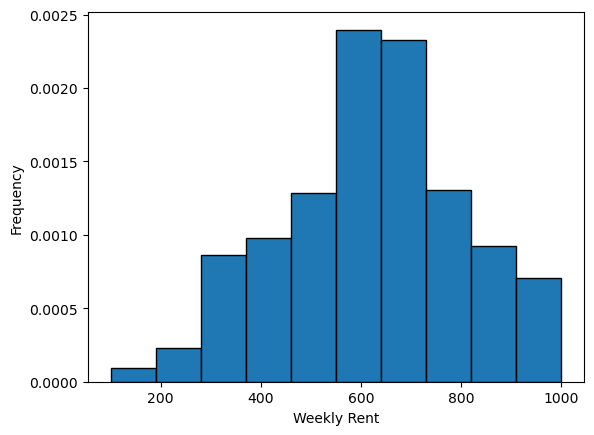

In [113]:
furnished_properties = properties[properties['furnished'] == True]

plt.hist(furnished_properties['weekly_rent'], range=[100, 1000], edgecolor='black', density=True)
plt.xlabel('Weekly Rent')
plt.ylabel('Frequency')
plt.show()

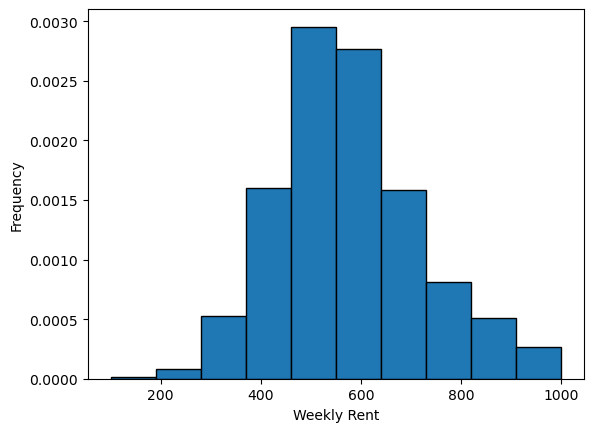

In [114]:
unfurnished_properties = properties[properties['furnished'] == False]

plt.hist(unfurnished_properties['weekly_rent'], range=[100, 1000], edgecolor='black', density=True)
plt.xlabel('Weekly Rent')
plt.ylabel('Frequency')
plt.show()

## Assumptions

In [140]:
# Month only
# properties[(properties['is_monthly'] == True) & (properties['is_weekly'] == False) & (properties['rent_nums'].apply(lambda x: len(x) > 1))]

# Weekly only
# properties[(properties['is_monthly'] == False) & (properties['is_weekly'] == True) & (properties['rent_nums'].apply(lambda x: len(x) > 1))][['rental_price', 'bond', 'price_furnished', 'features_furnished', 'desc_furnished', 'furnished', 'rent_nums', 'weekly_rent']]

# Both (most pcm == bond, when we removed bond we removed most pcm but it's fine cus we took the minimum for is_both)
# properties[(properties['is_both'] == True) & (properties['rent_nums'].apply(lambda x: len(x) == 1))].head(20)

# Bond (shows why we needed to remove bond) --> lost 2 records tho (properties[properties['weekly_rent'].isna()])
# properties[properties['rental_price'].str.contains('bond',case=False)]
 
# Not indicated
# properties[(properties['not_indicated'] == True) & (properties['rent_nums'].apply(lambda x: len(x) > 1))]

# 1 wack record:
# rental price = '$800 1,2 or 3 Month Lease' --> weekly rent = 184.1
# properties[properties['rental_price'].str.contains('month lease', case=False)]

####################################################################################################################################################################################

# there's an entry that's 800 but considered monthly due to "1,2,3 month lease"
# i think we can just get rid of this one property LOL idk how else 

# if contains_both_furnished_options = True, take the maximum of rent_nums & output to final_rent (new column)

# if not_indicated == True 
    # if len(rent_nums) > 1, we take the average
        # issue with one property: $600/$2607 
    # if len == 1
        # if rent_nums[0] > 5000 (we assume per week), we remove
        # else output to final_rent
        # if > 5000, we remove

# if monthly = True & weekly = False
    # if length rent_nums > 1, 
    #   we take the max of rent_nums , x 52 / 12, and output to final_rent
    # else if len == 1
        # if rent_nums[0] < 500, remove (most likly to be car park / storage)
        # else x 12 / 52 and output to final_rent

# if weekly = True & monthly = False
    # if len rent_nums > 1, 
    #   we take the minimum of rent_nums and output to final_rent (bc some rental prices include bond UGHH)
    # else we output to final_rent

    # if less than 125, we remove

# if is_both = True,
    # we take the minimum of rent_nums and output to final_rent


# if len rent_nums == 2
    # if is_both == False:
        # take average of rent_nums and output to final_rent
    # if is_both == True:
        # take minimum

####################################################################################################################################################################################

# if none & if less than 5000, assume weekly

    # remove greater than 5000

    # if pcm, x 12 / 52

    # if weekly, just take the number

    # if both, take the minimum

# find numerical values (if 1 and less than 5000, assume pw)

# if month, keep just the number

# if contains both furnished options, take the max

# If not_indicated = True & less than 5000, then we assume weekly

####################################################################################################################################################################################

## Assumptions

# Rental price only have numbers --> assume weekly for these

# get suburbs and postcode for address (DONE)
# rental_price per week
# split rooms into bed and bath (DONE)
# parking: list format into just number (DONE)
# features: furnished, pets (DONE)

# * is unconfirmed --> assume 0
# just 0's and 1's for all hot-encoded columns
# number of features would be len of features list
# check if furnished from description (only look for 'furnished' / 'unfurnished' in description)

# keep house & apartment
# townhouse in house
# new house & land to house
# semi detached --> house
# villa in house
# duplex to house

# studio in apt
# new apartments to apts

# if contain furnished --> flag, unless the str also contains 'extra'

# pw, per week, /w, weekly, a week, p.w, p.w., week, / week, /week, wk, / wk, 
# some just have the number --> assume weekly for these
# p.c.m., per month, /month, pcm, calendar month, pm

#################################################################################################################################################################################

# 5000 max per week

# $630 bills and wifi included
# could contain furnished / 'fully furnished' / 'partly-furnished', 'furnish', 'furnished!', 'fully furn'
# 'furnished option extra pw'

# problems: rent2own, for winter season, for the season, per night (get rid of these) (DONE)
# (starting) from xx per month
# $786 - $1572 (got rid of, parking > 12)

# for calendar month: x 12 / 52? 

# Assume if rent doesn't have like p/w or pcm, then if its less than 5000 --> pw, if greater than 5000 --> per month or per year?
# 95000 per year

# Get rid of all rental prices above 5000